In [5]:
import numpy as np
import pandas as pd
import os
import sys
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import seaborn as sns
import sklearn
from scipy import stats
%matplotlib inline
state = 32
np.random.seed(state)
print ('numpy version:', np.__version__, 'pandas version:', pd.__version__)

numpy version: 1.21.5 pandas version: 1.3.4


### READ DATA

In [6]:
df = pd.read_excel('vesselData.xlsx')
df

,eta,ata,atd,vesseldwt,vesseltype,discharge1,load1,discharge2,load2,discharge3,...,load4,stevedorenames,hasnohamis,earliesteta,latesteta,traveltype,previousportid,nextportid,isremarkable,vesselid
0,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,2017-09-22 00:00:00+00,109290.0,5.0,0.0,0.0,0.0,0.0,90173.0,...,0.0,Stevedore_104,NaN,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,ARRIVAL,981.0,731.0,f,2242.0
1,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,67170.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_109,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,19.0,15.0,f,5462.0
2,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,2017-10-01 00:00:00+00,67737.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,ARRIVAL,19.0,19.0,f,5251.0
3,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,43600.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,15.0,18.0,f,5268.0
4,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,9231.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_98,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,74.0,27.0,f,5504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017-11-03 00:00:00+00,2017-11-03 00:00:00+00,2017-11-04 00:00:00+00,9587.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_64,NaN,2017-11-02 00:00:00+00,2017-11-03 00:00:00+00,ARRIVAL,5.0,19.0,f,5681.0
8204,2017-11-04 00:00:00+00,2017-11-04 00:00:00+00,2017-11-06 00:00:00+00,9654.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,"Stevedore_110,Stevedore_57,Stevedore_99,Steved...",NaN,2017-11-04 00:00:00+00,2017-11-05 00:00:00+00,SHIFT,391.0,102.0,f,4843.0
8205,2017-11-08 00:00:00+00,2017-11-07 00:00:00+00,2017-11-11 00:00:00+00,4726.0,5.0,0.0,0.0,0.0,0.0,0.0,...,3051.0,"Stevedore_89,Stevedore_79,Stevedore_75,Stevedo...",NaN,2017-11-07 00:00:00+00,2017-11-10 00:00:00+00,SHIFT,1043.0,19.0,f,3115.0
8206,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,13320.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_46,NaN,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,ARRIVAL,54.0,71.0,f,4623.0


In [1]:
df.info()

NameError: name 'df' is not defined

### INVESTIGATE TARGET VARIABLES

In [8]:
targets_df = df[['load1', 'discharge1','load2', 'discharge2', 'load3', 'discharge3', 'load4', 'discharge4']]
targets_df

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
0,0.0,0.0,0.0,0.0,0.0,90173.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8205,0.0,0.0,0.0,0.0,0.0,0.0,3051.0,3537.0
8206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
targets_df.describe()

,load1,discharge1,load2,discharge2,load3,discharge3,load4,discharge4
count,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000
mean,60.754386,1732.712841,19.387549,1168.698221,44.745492,4791.331871,1509.046784,1820.782407
std,1325.463945,16297.994648,665.333248,11331.135301,3071.717973,25366.035772,11936.519585,10034.936858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,41761.000000,204304.000000,43639.000000,189933.000000,271251.000000,299647.000000,293449.000000,183837.000000


#### COUNT NON-ZERO TARGETS

In [10]:
for i in range(1,5):
    print (f'load{i}',targets_df.loc[targets_df[f'load{i}'] > 0, f'load{i}'].count())
print('-----')
for i in range(1,5):
    print (f'discharge{i}',targets_df.loc[targets_df[f'discharge{i}'] > 0, f'discharge{i}'].count())

load1 40
load2 21
load3 8
load4 446
-----
discharge1 138
discharge2 112
discharge3 378
discharge4 558


### TARGETS INITIAL INSIGHTS
Cargo type 4 (petrol) is the least type with missing load and discharge data (446 load/ 558 discharge).

Based on a quick search https://bulkcarrierguide.com/cargo.html, I made an assumption: <br>
The handling of ore & coal might be similar (i.e., solid bulk cargo). Likewise oil & petrol (i.e., liquid bulk) might have similar handling routines in terms of safety, regulations, transportation. <br>

Therefore:<br>
concatenate: load1 + load2 --> load_solid <br>
concatenate: load3 + load4 --> load_liquid <br>
concatenate: discharge1 + discharge2 --> discharge_solid <br>
concatenate: discharge3 + discharge4 --> discharge_liquid <br>

This is to maximize the supervision signal to train our predictive model.

In [11]:
valid_load1 = targets_df.loc[targets_df['load1'] > 0, 'load1']
valid_load2 = targets_df.loc[targets_df['load2'] > 0, 'load2']
load_solid = pd.concat([valid_load1, valid_load2] )

valid_load3 = targets_df.loc[targets_df['load3'] > 0, 'load3']
valid_load4 = targets_df.loc[targets_df['load4'] > 0, 'load4']
load_liquid = pd.concat([valid_load3, valid_load4] )
load_liquid


valid_disc1 = targets_df.loc[targets_df['discharge1'] > 0, 'discharge1']
valid_disc2 = targets_df.loc[targets_df['discharge2'] > 0, 'discharge2']
disc_solid= pd.concat([valid_disc1, valid_disc2] )
disc_solid


valid_disc3 = targets_df.loc[targets_df['discharge3'] > 0, 'discharge3']
valid_disc4 = targets_df.loc[targets_df['discharge4'] > 0, 'discharge4']
disc_liquid= pd.concat([valid_disc3, valid_disc4] )
disc_liquid 


0        90173.0
8        14044.0
27      131231.0
36       99862.0
50      102817.0
          ...   
8131      5104.0
8188     15980.0
8191      4196.0
8194     28127.0
8205      3537.0
Length: 936, dtype: float64

### FEATURES SELECTION & ENGINEERING

1. Dropping common sense non-informative features
2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
3. Construct a ```process_time``` feature as the difference in days from the 2 dates ```atd ``` - ```ata```
4. Construct a binary variable ```bulk_type``` to define the cargo type {'solid': 0, 'liquid': 1}


In [12]:
# 1. Dropping common sense non-informative features
exclusion_set = ['ata', 'atd','eta', 'previousportid', 'nextportid','earliesteta', 'stevedorenames', 'vesselid', 'latesteta', 'hasnohamis']
feature_candidates = ['vesseldwt', 'vesseltype', 'traveltype', 'isremarkable']
feature_df = df[['vesseldwt', 'vesseltype', 'traveltype']]
feature_df

,vesseldwt,vesseltype,traveltype
0,109290.0,5.0,ARRIVAL
1,67170.0,3.0,ARRIVAL
2,67737.0,3.0,ARRIVAL
3,43600.0,3.0,ARRIVAL
4,9231.0,3.0,ARRIVAL
...,...,...,...
8203,9587.0,3.0,ARRIVAL
8204,9654.0,3.0,SHIFT
8205,4726.0,5.0,SHIFT
8206,13320.0,3.0,ARRIVAL


In [13]:
# 2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
df['stevedorenames'] = df['stevedorenames'].astype('str')
feature_df['n_stevs'] = df['stevedorenames'].str.split(',').apply(lambda x : len(x))
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,vesseldwt,vesseltype,traveltype,n_stevs
0,109290.0,5.0,ARRIVAL,1
1,67170.0,3.0,ARRIVAL,1
2,67737.0,3.0,ARRIVAL,1
3,43600.0,3.0,ARRIVAL,1
4,9231.0,3.0,ARRIVAL,1
...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1
8204,9654.0,3.0,SHIFT,5
8205,4726.0,5.0,SHIFT,4
8206,13320.0,3.0,ARRIVAL,1


In [14]:
# 3. construct process_time feature
ata = pd.to_datetime(df['ata']).dt.date
atd = pd.to_datetime(df['atd']).dt.date
feature_df['process_time'] = (atd - ata).dt.days
feature_df

D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,vesseldwt,vesseltype,traveltype,n_stevs,process_time
0,109290.0,5.0,ARRIVAL,1,3
1,67170.0,3.0,ARRIVAL,1,1
2,67737.0,3.0,ARRIVAL,1,1
3,43600.0,3.0,ARRIVAL,1,1
4,9231.0,3.0,ARRIVAL,1,0
...,...,...,...,...,...
8203,9587.0,3.0,ARRIVAL,1,1
8204,9654.0,3.0,SHIFT,5,2
8205,4726.0,5.0,SHIFT,4,4
8206,13320.0,3.0,ARRIVAL,1,0


In [15]:
# 4. construct the bulk_type feature
disc_liquid = disc_liquid[~ disc_liquid.index.duplicated()]
solid_bulk = pd.concat([load_solid, disc_solid], axis = 1)
solid_bulk.insert(0,'bulk', value ='solid')
liquid_bulk = pd.concat([load_liquid, disc_liquid], axis = 1)
liquid_bulk.insert(0,'bulk',value= 'liquid')

targs = pd.concat([solid_bulk, liquid_bulk], axis= 0)
targs.columns = ['bulk','load', 'discharge']
targs



,bulk,load,discharge
5,solid,NaN,72741.0
23,solid,4188.0,NaN
44,solid,39786.0,NaN
62,solid,NaN,50743.0
88,solid,7005.0,NaN
...,...,...,...
8188,liquid,NaN,15980.0
8191,liquid,4206.0,4196.0
8192,liquid,NaN,139431.0
8194,liquid,NaN,28127.0


In [16]:
feature_df = feature_df.join(targs, how= 'right')
feature_df

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
0,109290.0,5.0,ARRIVAL,1,3,liquid,NaN,90173.0
5,74518.0,2.0,ARRIVAL,1,2,solid,NaN,72741.0
8,17069.0,5.0,ARRIVAL,1,1,liquid,NaN,14044.0
23,7133.0,3.0,ARRIVAL,1,1,solid,4188.0,NaN
27,158070.0,5.0,ARRIVAL,1,2,liquid,NaN,131231.0
...,...,...,...,...,...,...,...,...
8188,25432.0,5.0,ARRIVAL,1,2,liquid,NaN,15980.0
8191,4993.0,5.0,SHIFT,2,8,liquid,4206.0,4196.0
8192,158583.0,5.0,SHIFT,2,2,liquid,NaN,139431.0
8194,37296.0,5.0,ARRIVAL,1,4,liquid,NaN,28127.0


In [147]:
# Single missing ship weight value for a type 5 ship
feature_df.iloc[:,:-2][feature_df.iloc[:,:-2].isna().any(axis = 1)]

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk


In [148]:
# Impute the single missing vessel weight value with the median of all type 5 vessel weights  
vess5_medweight = feature_df.vesseldwt.loc [feature_df.vesseltype == 5].median()
feature_df['vesseldwt'] = feature_df['vesseldwt'].fillna(vess5_medweight)

Type casting ```vesseltype``` as type ```category```

In [149]:
feature_df['vesseltype'] = feature_df['vesseltype'].astype('category')
feature_df[['vesseltype','traveltype','bulk']].describe()

,vesseltype,traveltype,bulk
count,1606.0,1606,1606
unique,3.0,2,2
top,5.0,ARRIVAL,liquid
freq,1262.0,1312,1296


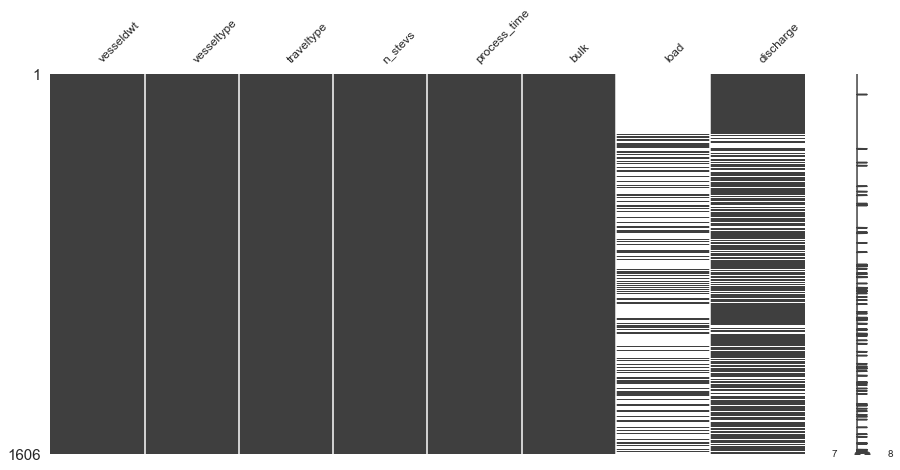

In [150]:
msno.matrix(feature_df.sort_values(by=['vesseltype'], ascending=True), figsize= (15,7), fontsize = 12)
plt.show()

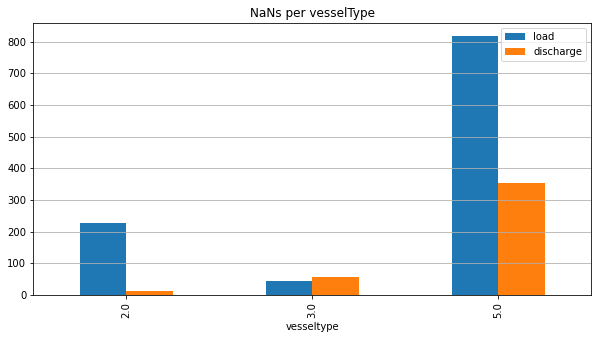

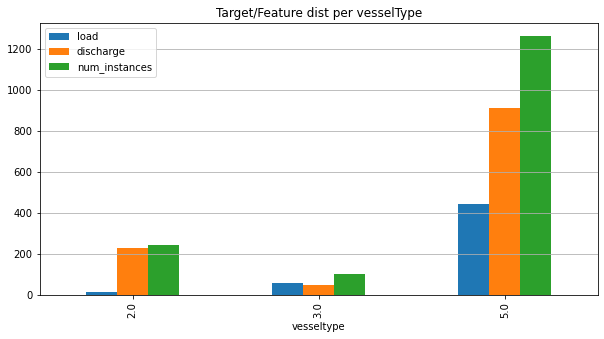

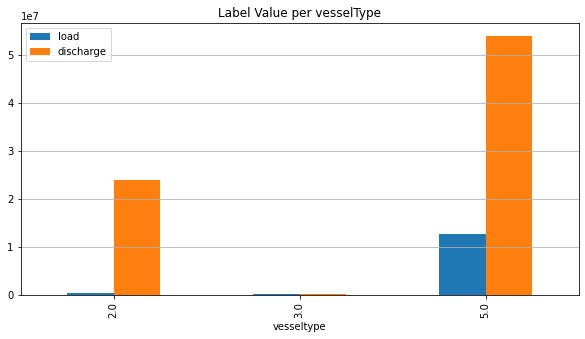

In [37]:
feature_df[['load','discharge']].isna().groupby(by=feature_df['vesseltype']).sum().plot.bar(figsize = (10,5), title = 'NaNs per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge', 'vesseltype']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Target/Feature dist per vesselType')
plt.legend(['load','discharge','num_instances']) 
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).sum().plot.bar(figsize = (10,5), title = 'Label Value per vesselType')
plt.grid(axis = 'y', linestyle='-')
# feature_df[['vesseltype']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Row Count per vesseltype')
plt.show()



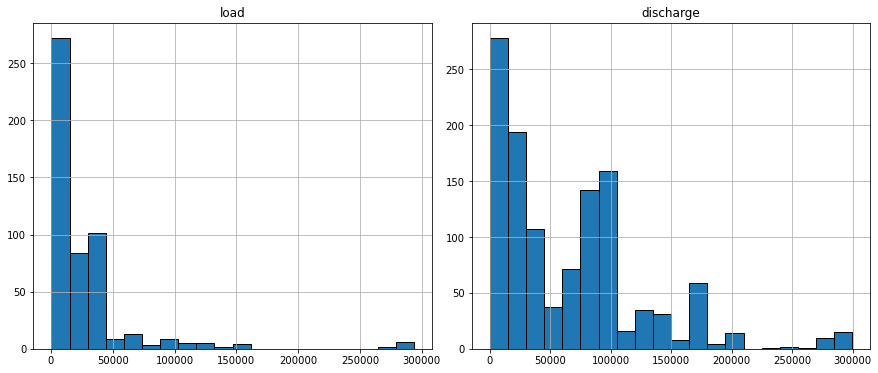

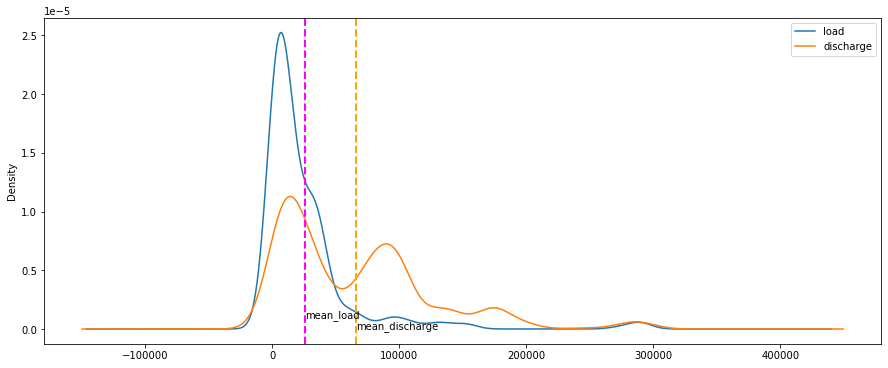

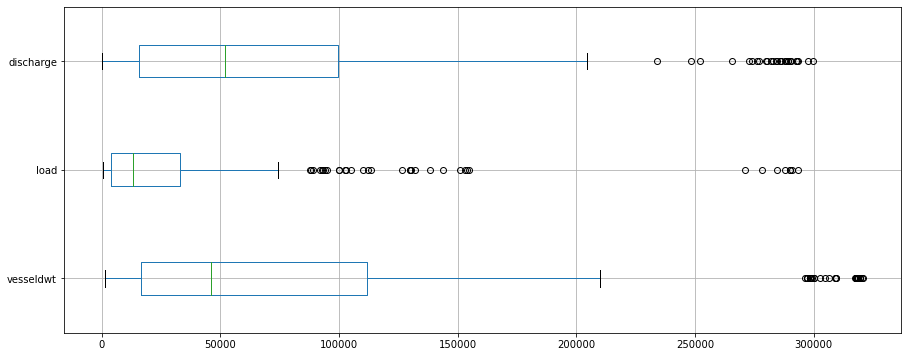

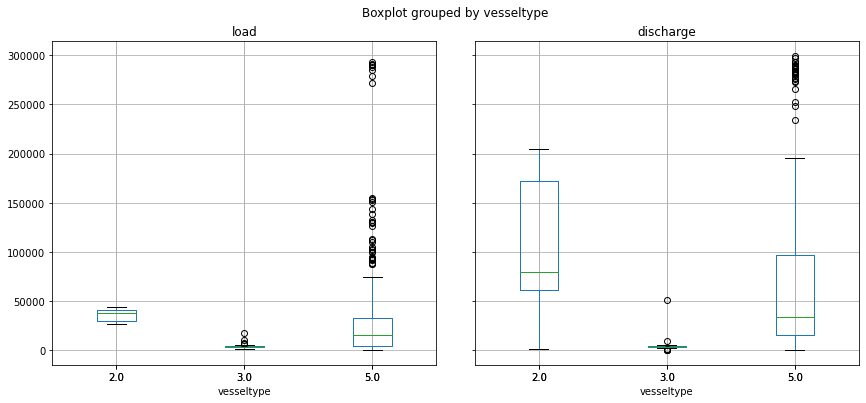

In [23]:
load_mean = feature_df['load'].mean()
discharge_mean = feature_df['discharge'].mean()
feature_df.hist(['load', 'discharge'], bins=20, figsize=(15,6), edgecolor='k')
plt.subplots_adjust(wspace= 0.1)
feature_df[['load','discharge']].plot.density(bw_method = 0.2, figsize = (15,6))
plt.axvline(x=load_mean, color = 'magenta', linestyle='dashed', linewidth = 2)
plt.axvline(x=discharge_mean, color = 'orange', linestyle='dashed', linewidth = 2)
plt.text(load_mean, y= 0.1e-5, s= 'mean_load')
plt.text(discharge_mean, y= 0, s= 'mean_discharge')
plt.subplots_adjust(wspace= 0.0001)
plt.show()
feature_df.boxplot(['vesseldwt','load','discharge'], vert = False, figsize=(15,6))
feature_df.boxplot(['load','discharge'], by='vesseltype', figsize=(14,6))
plt.subplots_adjust(wspace= 0.1)

plt.show()

#### FEATURE ENCODING:
One-hot encoding the categorical variables

In [152]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
encoded_df = pd.get_dummies(feature_df, columns=['vesseltype','traveltype','bulk'])
encoded_df

,vesseldwt,n_stevs,process_time,load,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,NaN,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,NaN,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,NaN,14044.0,0,0,1,1,0,1,0
23,7133.0,1,1,4188.0,NaN,0,1,0,1,0,0,1
27,158070.0,1,2,NaN,131231.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,NaN,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4206.0,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,NaN,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,NaN,28127.0,0,0,1,1,0,1,0


#### OBTAINING SEPARATE LOAD AND DISCHARGE DATAFRAMES

In [153]:
load_dataset = encoded_df.dropna(subset=['load']).drop('discharge', axis= 1)
discharge_dataset = encoded_df.dropna(subset=['discharge']).drop('load', axis= 1)
discharge_dataset

,vesseldwt,n_stevs,process_time,discharge,vesseltype_2.0,vesseltype_3.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,3,90173.0,0,0,1,1,0,1,0
5,74518.0,1,2,72741.0,1,0,0,1,0,0,1
8,17069.0,1,1,14044.0,0,0,1,1,0,1,0
27,158070.0,1,2,131231.0,0,0,1,1,0,1,0
36,111775.0,1,4,99862.0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,2,15980.0,0,0,1,1,0,1,0
8191,4993.0,2,8,4196.0,0,0,1,0,1,1,0
8192,158583.0,2,2,139431.0,0,0,1,0,1,1,0
8194,37296.0,1,4,28127.0,0,0,1,1,0,1,0


# MODELING

In [155]:
from sklearn.model_selection import train_test_split
X = discharge_dataset.drop('discharge', axis= 1)
y = discharge_dataset[['discharge']]

############################################
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size= 0.2, shuffle= True)
print (xtrain.shape, xtest.shape)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size= 0.25, shuffle= True)
print (xtrain.shape, xval.shape)

(947, 10) (237, 10)
(710, 10) (237, 10)


#### FITTING A PLAIN VANILLA XBGOOSTER

In [156]:
params = {'objective': 'reg:squarederror' , 'learning_rate': 0.3, 'gamma': 0, 'max_depth': 6, 'missing': 0, 'seed': 32 , 'subsample': 0.5, 'colsample_bytree': 0.5,
'reg_lambda': 0, 'n_estimators': 3000, 'eval_metric': ['mae','rmse']}
model = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
eval_sets = [ (xtrain, ytrain), (xval, yval)]
# model.get_xgb_params()

In [25]:
model.fit(xtrain, ytrain, eval_set= eval_sets, verbose= True, early_stopping_rounds= 10)

[0]	validation_0-mae:51711.48047	validation_0-rmse:73886.31250	validation_1-mae:52023.30078	validation_1-rmse:77462.50781
[1]	validation_0-mae:44776.72266	validation_0-rmse:63813.21094	validation_1-mae:45961.53906	validation_1-rmse:68276.35938
[2]	validation_0-mae:32953.67188	validation_0-rmse:46336.78516	validation_1-mae:33957.05469	validation_1-rmse:51024.32812
[3]	validation_0-mae:25371.34375	validation_0-rmse:35405.38672	validation_1-mae:26857.37109	validation_1-rmse:41185.52734
[4]	validation_0-mae:24247.29492	validation_0-rmse:33040.71094	validation_1-mae:25892.60156	validation_1-rmse:39106.83594
[5]	validation_0-mae:19597.45508	validation_0-rmse:26578.73633	validation_1-mae:21890.28906	validation_1-rmse:33460.60547
[6]	validation_0-mae:16318.77441	validation_0-rmse:21877.30273	validation_1-mae:19422.24219	validation_1-rmse:29477.58398
[7]	validation_0-mae:16158.78125	validation_0-rmse:21514.52930	validation_1-mae:19325.58984	validation_1-rmse:29168.49219
[8]	validation_0-mae:136

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eval_metric=['mae', 'rmse'], gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=0, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=32, reg_alpha=0, reg_lambda=0,
             scale_pos_weight=1, seed=32, subsample=0.5, tree_method='exact',
             validate_parameters=True, verbosity=1)

# SMOGN

In [47]:
from  importlib import reload
import utils
reload(utils)
from utils import *
import smogn
reload(smogn)
from smogn import *

traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()
train_balanced = smogn.smoter(data= traindata, y= 'discharge')
simple = train_balanced.reset_index()

r_index: 100%|##########| 88/88 [00:00<00:00, 456.16it/s]


In [102]:
traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()
train_balanced_adv = smogn.smoter(data= traindata, y='discharge',
                                k = 5,
                                pert = 0.04,
                                samp_method = 'balance',
                                drop_na_col = False,
                                drop_na_row = True,
                                replace = True,
                                rel_thres = .6,
                                rel_method = 'auto',
                                rel_xtrm_type = 'both',
                                rel_coef = 1.8
                                )
adv = train_balanced_adv.reset_index()

r_index: 100%|##########| 44/44 [00:00<00:00, 485.49it/s]


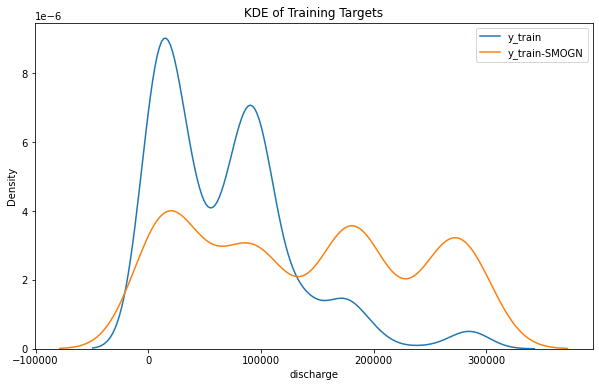

In [109]:
traindata = pd.concat([xtrain, ytrain],axis= 1).reset_index()

fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.kdeplot(traindata.discharge, ax = ax)
# # sns.kdeplot(simple.discharge, ax = ax[1])
sns.kdeplot(adv.discharge, ax = ax)
plt.legend(['y_train', 'y_train-SMOGN'])
plt.title('KDE of Training Targets')
plt.show()



In [29]:
xtrain_smg = train_balanced_adv.iloc[:,:-1]
ytrain_smg = train_balanced_adv[['discharge']]

# LDS --> KERNEL SMOOTHING

What you should have done is first split the data into train and test and then perform all the usampling on the train and create a model and then test it on test data. You don't touch or modify the test data. 

This way you can actually prevent the data leakage. Now because you have upsampled first and then split, obviously your model would be better for every class. But I dont think it is a true generalized representation. You can use stratified splitting before splitting the data to represent all the class labels.

In [281]:
from  importlib import reload
import utils
reload(utils)
from utils import *
import smogn
reload(smogn)
from smogn import *

In [111]:
lds = LDS(labels= ytrain.discharge, buffer= 10000)
bin_df = lds.bin_dataframe(ytrain)
x_wts_df = lds.weight_df(bin_df, weight= 'inverse')
x_wts_df

,discharge,bin,inverse
5934,96562.0,97000,1.457735
1085,75279.0,76000,1.341116
5712,59203.0,60000,1.457735
6203,16001.0,17000,0.493057
2376,78448.0,79000,1.117597
...,...,...,...
6383,165516.0,166000,1.523996
4523,100052.0,101000,0.399142
878,59010.0,60000,1.457735
7296,31272.0,32000,0.957940


D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


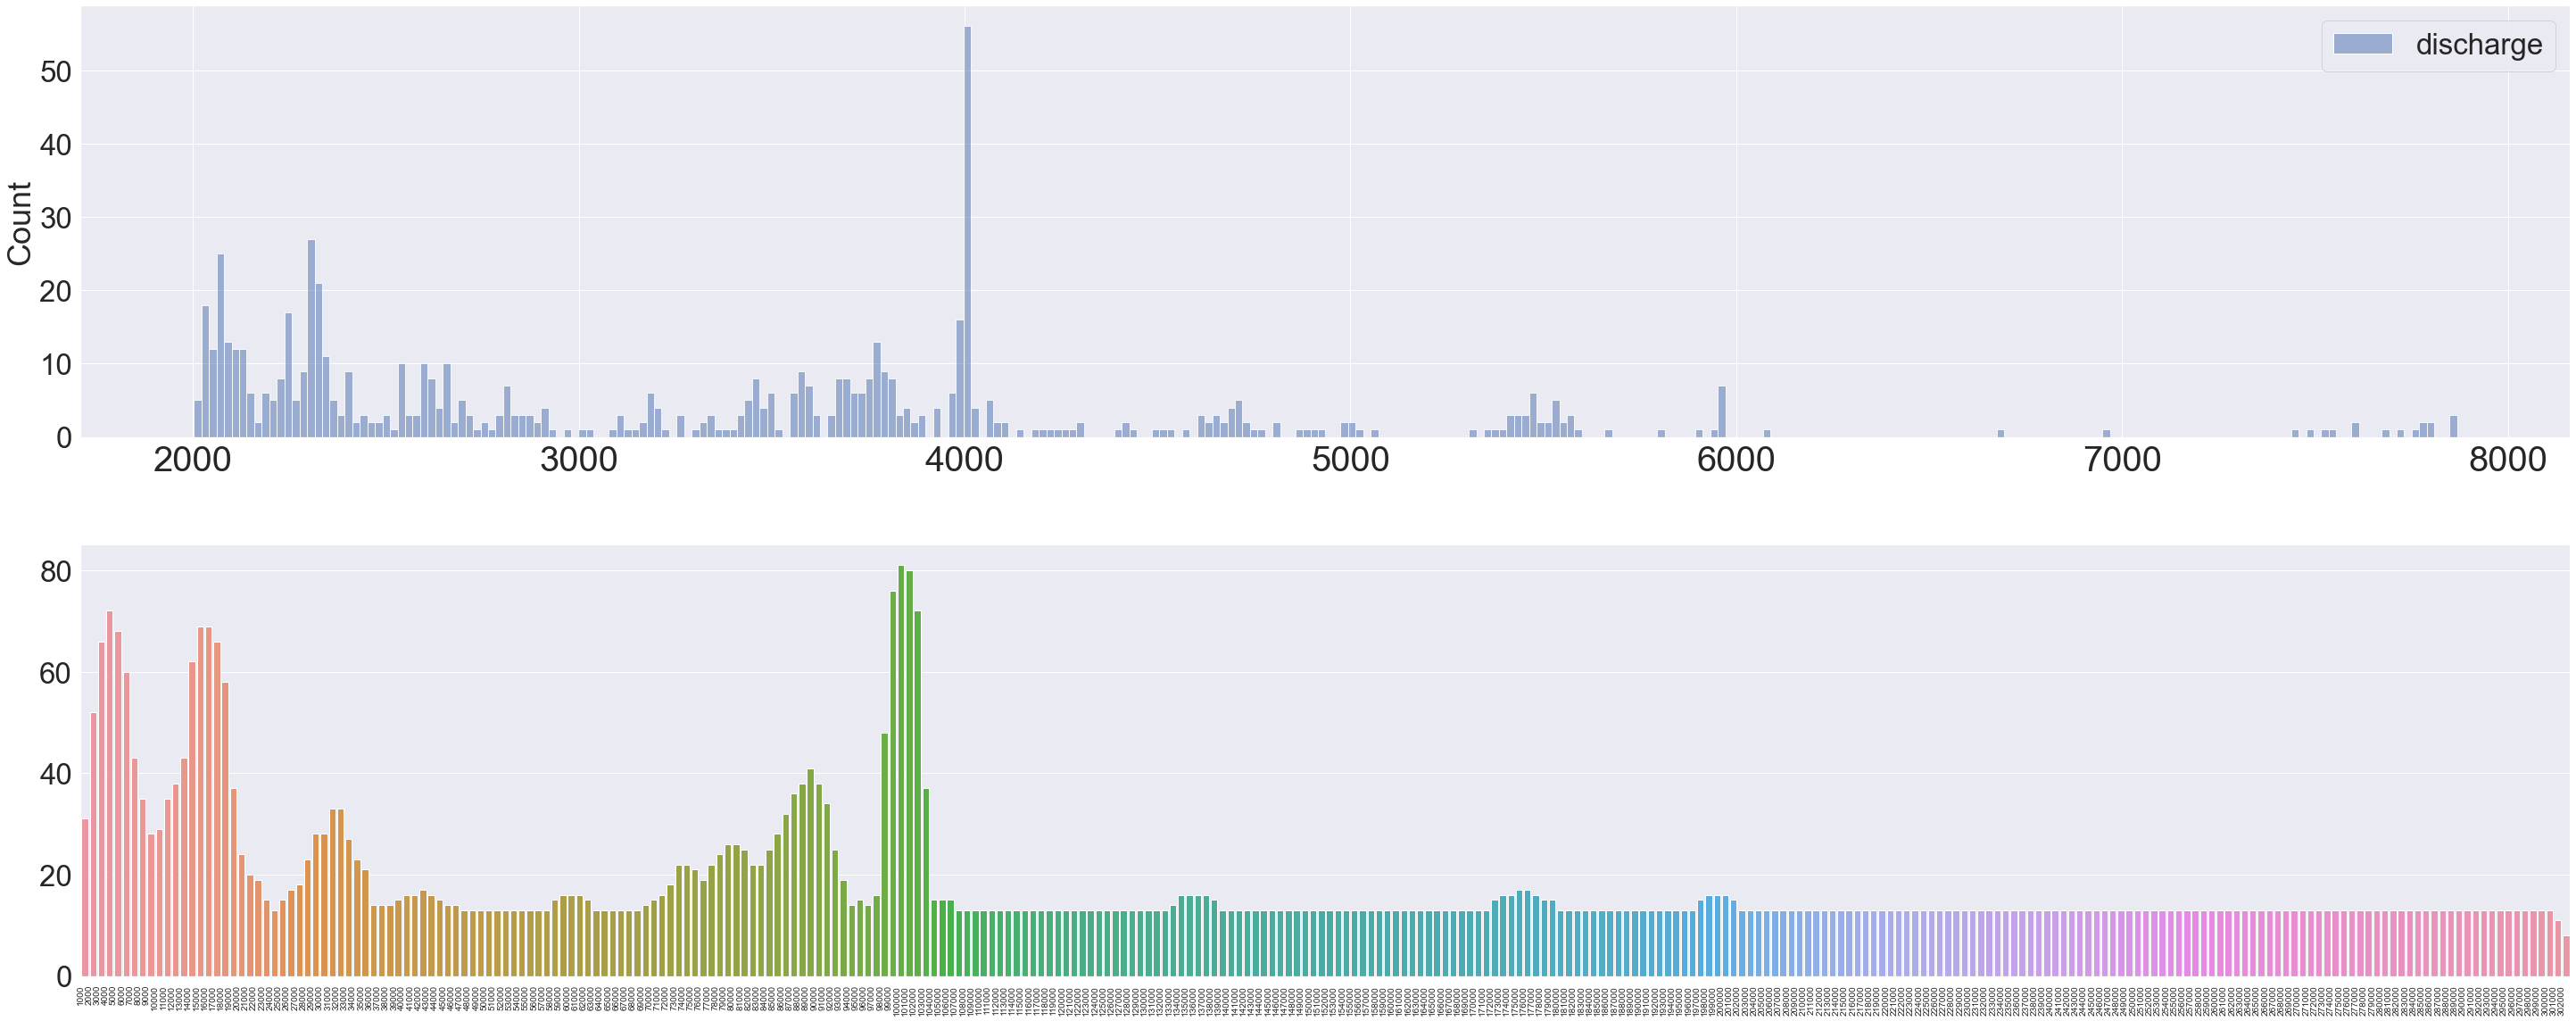

In [145]:
smoothed, emp = lds.effective_dist(smooth= 3)
bins, freqs = zip(*emp.items())
fig, (ax0, ax1) = plt.subplots(2,1, figsize= (50,20), )
# sns.barplot(x= list(bins), y= list(freqs), ax =ax0)
# ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90, ha='right')
sns.set(font_scale = 3)
sns.histplot(data= ytrain, ax =ax0, bins = 300)
ax0.set_xticklabels(bins, fontsize = 40)

bins, freqs = zip(*smoothed.items())
p = sns.barplot(x= list(bins), y= list(freqs), ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right', fontsize = 10)
plt.subplots_adjust(hspace= .25)
plt.show()

### Training the best model with LDS

In [31]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV,ShuffleSplit, PredefinedSplit, LeaveOneOut, cross_val_score, cross_val_predict, KFold, GroupKFold, HalvingRandomSearchCV, RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error
from scipy.stats import t

#### A VERY SIMPLE SEARCH: 10 cand; 1 repeat

In [50]:
model_cv = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
rpt_cv = RepeatedKFold(n_splits=2, n_repeats= 1, random_state= state)
splts = list (rpt_cv.split(X, y) )
len(splts) # 4 x 10 = 40
print(len(splts[0]) , len(splts[0][0]), len(splts[0][1])) # train/test splits of Itr 0, len_trainSplit, len_testSplit (2, 710, 237)



2 592 592


#### SEARCH SPACE

In [33]:
#### SEARCH DISTs
gamma_dist = stats.betaprime(a = 2,b =6, scale = 10)
sample = gamma_dist.rvs(size= 1000)
print( min(sample), max(sample) )


lambda_dist = stats.expon(scale = 3)
sample = lambda_dist.rvs(size= 1000)
print( min(sample), max(sample) )


lr_dist = stats.loguniform(.0001, .5)
sample = lr_dist.rvs(size= 1000)
print (min(sample), max(sample))

maxchild_dist = stats.nbinom(2, .4, loc = 1)
sample = maxchild_dist.rvs(size= 1000)
print (min(sample), max(sample))

colrow_dist = stats.beta(2.5,1)
sample = colrow_dist.rvs(size= 1000)
print (min(sample), max(sample))

treedepth_dist = stats.nbinom(20, .5)
sample = treedepth_dist.rvs(size= 1000)
print (min(sample), max(sample))


0.03678787213718633 35.099680942497976
0.003057586931399135 22.510957298687895
0.00010053313186577682 0.4952723094427882
1 18
0.02557684486775704 0.9995811733169958
5 42


In [51]:

search_space = {'objective': ['reg:squarederror'],
                'learning_rate':lr_dist,
                'max_depth':treedepth_dist,
                'subsample': colrow_dist,
                'colsample_bytree': colrow_dist,
                'reg_lambda': lambda_dist,
                'min_child_weight': maxchild_dist,
                'gamma': gamma_dist}

scssh_search = HalvingRandomSearchCV(model_cv, cv = rpt_cv, param_distributions= search_space, 
                                    n_candidates= 10, min_resources= 'exhaust', factor= 2,
                                    resource= 'n_samples', verbose= 5, n_jobs= -1, 
                                    scoring= 'neg_median_absolute_error', random_state= state, refit= True) 

In [184]:
# NESTED CV
outer_cv = KFold(n_splits= 3, shuffle= True, random_state= state)
# nestedcv = cross_validate(scssh_search, X, y, cv= outer_cv, scoring= 'neg_median_absolute_error', return_estimator= True, n_jobs= 6, verbose= 1)


In [101]:
pd.DataFrame(nestedcv)

,fit_time,score_time,estimator,test_score
0,193.191486,0.034563,HalvingRandomSearchCV(cv=RepeatedKFold(n_repea...,-4909.302734
1,191.157095,0.038756,HalvingRandomSearchCV(cv=RepeatedKFold(n_repea...,-6184.832031


### Weighted training

In [248]:
def apply_smogn (xsplit, ysplit, target_col = 'discharge'):

    train_df= pd.concat([xsplit, ysplit],axis= 1).reset_index(drop= True)
    df_smg = smoter(data= train_df, y= target_col,
                                    k = 8,
                                    pert = 0.04,
                                    samp_method = 'extreme',
                                    drop_na_col = True,
                                    drop_na_row = True,
                                    replace = True,
                                    rel_thres = .45,
                                    rel_method = 'auto',
                                    rel_xtrm_type = 'both',
                                    rel_coef = 1.5
                                    )
        
    x_smg = df_smg.iloc[:,:-1]
    y_smg = df_smg[[target_col]]

    return x_smg, y_smg

In [189]:
outer_cv = KFold(n_splits= 2, shuffle= True, random_state= state)

In [239]:
from sklearn.metrics import median_absolute_error

def score_pipline(X_cv, y_cv, outer_cv, search_cv, search_space):

    splits = list(outer_cv.split(X_cv, y_cv))
    scores = np.zeros(len(list(splits)))
    out = []

    for n_splt, splt in enumerate(splits):
        train_idxs, val_idxs = splt
        splt_xtrn, splt_ytrn = X_cv.iloc[train_idxs] , y_cv.iloc[train_idxs]
        splt_xval, splt_yval = X_cv.iloc[val_idxs] , y_cv.iloc[val_idxs]

        splt_xtrn, splt_ytrn = apply_smogn(splt_xtrn, splt_ytrn)

        lds= LDS(labels= splt_ytrn.discharge, buffer= 10000)
        binned = lds.bin_dataframe(splt_ytrn)
        x_wts =lds.weight_df(binned).inverse * 3
        wtd_loss = weightloss(weights= x_wts)

        search_space['objective'] = ['reg:squarederror', wtd_loss.weighted_mse]
        search_cv.param_distributions = search_space
        best_i = search_cv.fit(splt_xtrn, splt_ytrn )

        valpred = best_i.predict(splt_xval)
        score_i = median_absolute_error(splt_yval, valpred )
        scores[n_splt] = score_i
        out.append((best_i, score_i))

    return pd.DataFrame(out, columns= ['model', 'scores'])

    # print (n_splt, rpt_splits[n_splt][0].shape, rpt_splits[n_splt][1].shape)
    

In [ ]:
search_space = {'objective': ['reg:squarederror', wtd_loss],
                'learning_rate':lr_dist,
                'max_depth':treedepth_dist,
                'subsample': colrow_dist,
                'colsample_bytree': colrow_dist,
                'reg_lambda': lambda_dist,
                'min_child_weight': maxchild_dist,
                'gamma': gamma_dist}

In [246]:
def updateloss (splt_ytrn, buffer, amplifier):
    lds= LDS(labels= splt_ytrn.discharge, buffer= buffer)
    binned = lds.bin_dataframe(splt_ytrn)
    x_wts =lds.weight_df(binned).inverse * amplifier
    wtd_loss = weightloss(weights= x_wts)
    
    return wtd_loss.weighted_mse

In [245]:
def score_model (model, xt, yt, xv,yv ):

    model = model.fit(xt, yt)
    valpred = model.predict(xv)
    score_i = median_absolute_error(yv, valpred )
    return score_i

In [300]:
def score_param(X_cv, y_cv, itr_params, cv):

    splits = list(cv.split(X_cv, y_cv))
    scores = np.zeros(len(list(splits)))

    for n_splt, splt in enumerate(splits):
        train_idxs, val_idxs = splt
        splt_xtrn, splt_ytrn = X_cv.iloc[train_idxs] , y_cv.iloc[train_idxs]
        splt_xval, splt_yval = X_cv.iloc[val_idxs] , y_cv.iloc[val_idxs]

        splt_xtrn, splt_ytrn = apply_smogn(splt_xtrn, splt_ytrn)

        # wtd_loss = updateloss (splt_ytrn, buffer = 10000, amplifier= 3)
        loss_updater = loss(labels = splt_ytrn.discharge, buffer= 10000, amp= 1)
        _ = loss_updater.get_weights()
        wtd_loss = loss_updater.weighted_mse


        itr_params['objective'] = wtd_loss
        model_i = xgb.XGBRegressor(**itr_params, verbosity = 1, validate_parameters = True)

        score_i = score_model (model_i, splt_xtrn, splt_ytrn, splt_xval, splt_yval)

        scores[n_splt] = score_i

    return model_i, scores.mean()

    # print (n_splt, rpt_splits[n_splt][0].shape, rpt_splits[n_splt][1].shape)
    

In [244]:
def random_search(x_fold, y_fold, n_candids, params):
    itr_params  =params.copy()
    tracker = []
    for iter in range(n_candids):
        itr_params['learning_rate']     = lr_dist.rvs(size=1).item()
        itr_params['max_depth']         = treedepth_dist.rvs(size=1).item()
        itr_params['subsample']         = colrow_dist.rvs(size=1).item()
        itr_params['colsample_bytree']  = colrow_dist.rvs(size=1).item()
        itr_params['reg_lambda']        = lambda_dist.rvs(size=1).item()
        itr_params['min_child_weight']  = maxchild_dist.rvs(size=1).item()
        itr_params['learning_rate']     = lr_dist.rvs(size=1).item()
        
        model, mean_score = score_param(x_fold, y_fold, itr_params, cv= rpt_cv)
        tracker.append((model, mean_score))

    scores_df = pd.DataFrame(tracker, columns= ['model', 'score'])
    best_model = scores_df.loc[scores_df['score'] == scores_df.score.min(), 'model'].item()

    return best_model, scores_df

In [301]:
# best_model, scores_df = random_search (X, y, params,rpt_cv) #5359.42919921875, 262.400887306297


r_index: 100%|##########| 46/46 [00:00<00:00, 234.55it/s]


In [251]:
def nested_validation(X, y, outer_cv, params, n_candids, buffer, amp):
    outer_tracker = []

    for fold in outer_cv.split(X,y):
        x_fold, y_fold = fold
        xtrn, ytrn = X.iloc[x_fold] , y.iloc[x_fold]
        xtst, ytst = X.iloc[y_fold] , y.iloc[y_fold]

        best_model, scores_df = random_search (xtrn, ytrn, n_candids, params)
        xtrn_aug, ytrn_aug = apply_smogn(xtrn, ytrn)
        wtd_loss = updateloss (ytrn_aug, buffer = buffer, amplifier= amp)

        best_model.set_params(objective = wtd_loss)
        score_k = score_model (best_model, xtrn_aug, ytrn_aug, xtst , ytst)
        
        outer_tracker.append((best_model, score_k))

    scores_df = pd.DataFrame(outer_tracker, columns= ['model', 'score'])
    best_model = scores_df.loc[scores_df['score'] == scores_df.score.min(), 'model'].item()
    return best_model, scores_df



    
best_model, scores_df = nested_validation(X, y, outer_cv, params, 2, 10000, 1)

r_index: 100%|##########| 46/46 [00:00<00:00, 330.42it/s]
